In [54]:
!python3 -m pip install  --user    --no-warn-script-location 'google-cloud-bigquery' 'db-dtypes' 'pandas' 'pyarrow' 'kfp==1.8.14'

In [55]:

#!pip3 install virtualenv
#!virtualenv roonenv
#!source roonenv/bin/activate
#roonenv/bin/pip install google-cloud-aiplatform
#!roonenv/bin/pip3 install --upgrade google-cloud-aiplatform 
#!roonenv/bin/pip3 install -U google-cloud-storage  
#!roonenv/bin/pip3 install  kfp google-cloud-pipeline-components --upgrade
#!roonenv/bin/pip3 install 'google-cloud-bigquery[pandas]' 
!pip3 install --user google-cloud-aiplatform -U
#!pip3 install  --upgrade google-cloud-aiplatform 
#!pip3 install -U google-cloud-storage  
!pip3 install --user google-cloud-pipeline-components -U
!pip3 install --user  kfp -U
#!pip3 install 'google-cloud-bigquery[pandas]' 
#RROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
#google-cloud-pipeline-components 1.0.25 requires google-cloud-aiplatform<2,>=1.11.0, but you have google-cloud-aiplatform 1.7.0 which is incompatible.

In [56]:
# Automatically restart kernel after installs
import os
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [58]:
!python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"

KFP SDK version: 1.8.14


In [59]:
PROJECT_ID ="raniamoh-playground"

In [60]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "raniamoh-playground":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: raniamoh-playground


In [61]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [62]:
#!gcloud services enable compute.googleapis.com         \
                 #      containerregistry.googleapis.com  \
                 #      aiplatform.googleapis.com

In [63]:
REGION = "us-central1"

In [64]:
BUCKET_NAME = "gs://{}-bucket-ai-pip".format(PROJECT_ID)
!gsutil mb -l us-central1 $BUCKET_NAME # You only need to run this once

Creating gs://raniamoh-playground-bucket-ai-pip/...
ServiceException: 409 A Cloud Storage bucket named 'raniamoh-playground-bucket-ai-pip' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [65]:
import matplotlib.pyplot as plt
import pandas as pd
# We'll use this beta library for metadata querying
from google.cloud import aiplatform as aip, aiplatform_v1beta1 as aipbeta
from google.cloud.aiplatform import pipeline_jobs 
from kfp.v2 import compiler, dsl
from kfp.v2.dsl import (Artifact, Dataset, Input, Metrics, Model, Output,
                        OutputPath, component)
from google.oauth2 import service_account as sa
import logging as log
import google.cloud.logging_v2 as logv2
from os import environ

In [66]:
PATH = get_ipython().run_line_magic("env", "PATH")
%env PATH={PATH}:/home/jupyter/.local/bin
REGION = "us-central1"
project = "raniamoh-playground"
PIPELINE_ROOT = f"{BUCKET_NAME}/demo_dry_bean_pipeline_root/"
PIPELINE_ROOT
shell_output = !gcloud auth list 2>/dev/null
SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()
print("Service Account:", SERVICE_ACCOUNT)
shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = shell_output[0]
print("Project ID: ", PROJECT_ID)

env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin
Service Account: 189908348872-compute@developer.gserviceaccount.com
Project ID:  raniamoh-playground


In [67]:
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
!export GOOGLE_APPLICATION_CREDENTIALS="/home/jupyter/src/myplayground/raniamoh-playground-ai.json"
!gcloud auth activate-service-account ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com --key-file="/home/jupyter/src/myplayground/raniamoh-playground-ai.json"
!gcloud iam service-accounts add-iam-policy-binding 189908348872-compute@developer.gserviceaccount.com  --member=serviceAccount:ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com  --role=roles/iam.serviceAccountUser --project=raniamoh-playground
!gcloud iam service-accounts add-iam-policy-binding ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com  --member=serviceAccount:ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com  --role=roles/iam.serviceAccountUser --project=raniamoh-playground

Activated service account credentials for: [ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com]
Updated IAM policy for serviceAccount [189908348872-compute@developer.gserviceaccount.com].
bindings:
- members:
  - user:admin@raniamoh.altostrat.com
  role: roles/iam.serviceAccountAdmin
- members:
  - serviceAccount:ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com
  - serviceAccount:service-189908348872@compute-system.iam.gserviceaccount.com
  role: roles/iam.serviceAccountUser
etag: BwXrTCBWjiY=
version: 1
Updated IAM policy for serviceAccount [ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com].
bindings:
- members:
  - serviceAccount:189908348872-compute@developer.gserviceaccount.com
  - serviceAccount:ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com
  - user:admin@raniamoh.altostrat.com
  role: roles/iam.serviceAccountUser
etag: BwXrTCB5xF0=
version: 1


In [68]:
aip.init(project=PROJECT_ID, location=REGION, credentials=sa.Credentials.from_service_account_file(
    '/home/jupyter/src/myplayground/raniamoh-playground-ai.json'))


In [69]:
@component(
    base_image="python:3.9",
    packages_to_install=["google-cloud-bigquery", "db-dtypes", "pandas", "pyarrow"],
    output_component_file="create_dataset.yaml",
)
def get_dataframe(bq_table: str, project: str, output_data_path: OutputPath("Dataset")):
    from google.cloud import bigquery
    import logging as log
    
    bqclient = bigquery.Client(project=project)
    table = bigquery.TableReference.from_string(bq_table)
    rows = bqclient.list_rows(table)
    dataframe = rows.to_dataframe(
        create_bqstorage_client=True,
    )
    dataframe = dataframe.sample(frac=1, random_state=2)
    dataframe.to_csv(output_data_path)

In [70]:
@component(
    packages_to_install=["sklearn", "pandas", "joblib"],
    base_image="python:3.9",
    output_component_file="beans_model_component.yaml",
)
def sklearn_train(
    dataset: Input[Dataset], metrics: Output[Metrics], model: Output[Model]
):
    import pandas as pd
    from joblib import dump
    from sklearn.model_selection import train_test_split
    from sklearn.tree import DecisionTreeClassifier
    import logging as log
    
    df = pd.read_csv(dataset.path)
    labels = df.pop("Class").tolist()
    data = df.values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(data, labels)

    skmodel = DecisionTreeClassifier()
    skmodel.fit(x_train, y_train)
    score = skmodel.score(x_test, y_test)
    print("accuracy is:", score)

    metrics.log_metric("accuracy", (score * 100.0))
    metrics.log_metric("framework", "Scikit Learn")
    metrics.log_metric("dataset_size", len(df))
    dump(skmodel, model.path + ".joblib")
    log.info("Model %s",model.path)

In [71]:
@component(
    packages_to_install=["google-cloud-aiplatform"],
    base_image="python:3.9",
    output_component_file="beans_deploy_component.yaml",
)
def deploy_model(
    model: Input[Model],
    project: str,
    region: str,
    vertex_endpoint: Output[Artifact],
    vertex_model: Output[Model],
):
    from google.cloud import  aiplatform as aip
    import logging as log

    aip.init(project=project, location=region)

    deployed_model = aip.Model.upload(
        display_name="demo-dry-beans-model-pipeline",
        artifact_uri=model.uri.replace("model", ""),
        serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest",
    )
    
    log.info("After cont serve")
    endpoint = deployed_model.deploy(machine_type="n1-standard-4")

    # Save data to the output params
    vertex_endpoint.uri = endpoint.resource_name
    vertex_model.uri = deployed_model.resource_name
    log.info("Model2 %s", vertex_model.uri)

In [72]:
@dsl.pipeline(
    # Default pipeline root. You can override it when submitting the pipeline.
    pipeline_root=PIPELINE_ROOT,
    # A name for the pipeline.
    name="demo-dry-beans-pipeline",
)
def pipeline(
    bq_table: str = "",
    output_data_path: str = "data.csv",
    project: str = PROJECT_ID,
    region: str = REGION,
):
    dataset_task = get_dataframe(bq_table, project=project)

    model_task = sklearn_train(dataset_task.output)

    deploy_model(model=model_task.outputs["model"], project=project, region=region)

In [73]:
compiler.Compiler().compile(pipeline_func=pipeline, package_path="demo-dry-beans-pipeline.json")


/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1293: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


In [74]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [75]:
run1 = pipeline_jobs.PipelineJob(
    display_name="demo-dry-beans-pipeline",
    template_path="demo-dry-beans-pipeline.json",
    job_id="demo-dry-beans-pipeline-large-{}".format(TIMESTAMP),
    parameter_values={"bq_table": "raniamoh-playground.my_beans_demo.beans_large_dataset"},
    enable_caching=True,
)

In [76]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [77]:
run2 = pipeline_jobs.PipelineJob(
    display_name="demo-dry-beans-pipeline",
    template_path="demo-dry-beans-pipeline.json",
    job_id="demo-dry-beans-pipeline-small-{}".format(TIMESTAMP),
    parameter_values={"bq_table": "raniamoh-playground.my_beans_demo.beans_small_dataset"},
    enable_caching=True,
)

In [78]:
PATH = get_ipython().run_line_magic("env", "PATH")
%env PATH={PATH}:/home/jupyter/.local/bin
REGION = "us-central1"
project = "raniamoh-playground"
PIPELINE_ROOT = f"{BUCKET_NAME}/dry_bean_pipeline_root/"
PIPELINE_ROOT
run1.submit(service_account="ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com")


env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin
Creating PipelineJob
PipelineJob created. Resource name: projects/189908348872/locations/us-central1/pipelineJobs/demo-dry-beans-pipeline-large-20221018095758
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/189908348872/locations/us-central1/pipelineJobs/demo-dry-beans-pipeline-large-20221018095758')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/demo-dry-beans-pipeline-large-20221018095758?project=189908348872


In [79]:
PATH = get_ipython().run_line_magic("env", "PATH")
%env PATH={PATH}:/home/jupyter/.local/bin
REGION = "us-central1"
project = "raniamoh-playground"
PIPELINE_ROOT = f"{BUCKET_NAME}/dry_bean_pipeline_root/"
PIPELINE_ROOT
run2.submit(service_account="ai-piplinesa@raniamoh-playground.iam.gserviceaccount.com")


env: PATH=/usr/local/cuda/bin:/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin:/home/jupyter/.local/bin
Creating PipelineJob
PipelineJob created. Resource name: projects/189908348872/locations/us-central1/pipelineJobs/demo-dry-beans-pipeline-small-20221018095759
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/189908348872/locations/us-central1/pipelineJobs/demo-dry-beans-pipeline-small-20221018095759')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/demo-dry-beans-pipeline-small-20221018095759?project=189908348872


In [80]:
df = aip.get_pipeline_df(pipeline="demo-dry-beans-pipeline")
print(df)

              pipeline_name                                      run_name  \
0   demo-dry-beans-pipeline  demo-dry-beans-pipeline-large-20221018095758   
1   demo-dry-beans-pipeline  demo-dry-beans-pipeline-small-20221018095045   
2   demo-dry-beans-pipeline  demo-dry-beans-pipeline-large-20221018095045   
3   demo-dry-beans-pipeline  demo-dry-beans-pipeline-small-20221018094635   
4   demo-dry-beans-pipeline  demo-dry-beans-pipeline-large-20221018094635   
5   demo-dry-beans-pipeline  demo-dry-beans-pipeline-small-20221018093622   
6   demo-dry-beans-pipeline  demo-dry-beans-pipeline-large-20221018093620   
7   demo-dry-beans-pipeline  demo-dry-beans-pipeline-large-20221018093040   
8   demo-dry-beans-pipeline  demo-dry-beans-pipeline-small-20221018084813   
9   demo-dry-beans-pipeline  demo-dry-beans-pipeline-large-20221018084811   
10  demo-dry-beans-pipeline  demo-dry-beans-pipeline-small-20221017204251   
11  demo-dry-beans-pipeline  demo-dry-beans-pipeline-large-20221017204249   

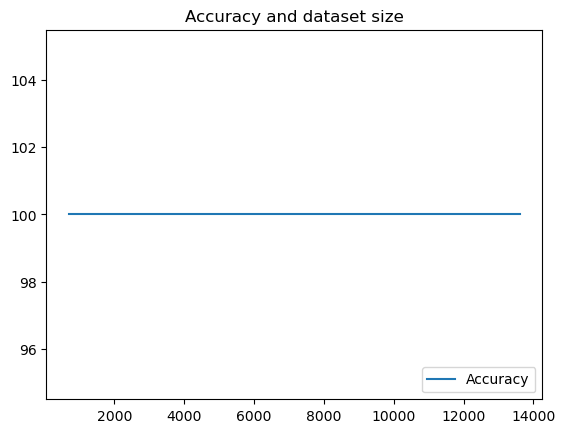

In [81]:
plt.plot(df["metric.dataset_size"], df["metric.accuracy"], label="Accuracy")
plt.title("Accuracy and dataset size")
plt.legend(loc=4)
plt.show()

In [82]:
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
metadata_client = aipbeta.MetadataServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

In [83]:
MODEL_FILTER = 'schema_title = "system.Model"'
artifact_request = aipbeta.ListArtifactsRequest(
    parent="projects/{}/locations/{}/metadataStores/default".format(PROJECT_ID, REGION),
    filter=MODEL_FILTER,
)
model_artifacts = metadata_client.list_artifacts(artifact_request)

In [84]:
LIVE_FILTER = 'create_time > "2021-08-10T00:00:00-00:00" AND state = LIVE'
artifact_req = {
    "parent": "projects/{}/locations/{}/metadataStores/default".format(
        PROJECT_ID, REGION
    ),
    "filter": LIVE_FILTER,
}
live_artifacts = metadata_client.list_artifacts(artifact_req)

In [85]:
data = {"uri": [], "createTime": [], "type": []}

for i in live_artifacts:
    data["uri"].append(i.uri)
    data["createTime"].append(i.create_time)
    data["type"].append(i.schema_title)

df = pd.DataFrame.from_dict(data)
print(df)

                                                  uri  \
0   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
1   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
2   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
3   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
4   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
5   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
6   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
7   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
8   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
9   gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
10  gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
11  gs://raniamoh-playground-bucket-ai-pip/demo_dr...   
12  gs://raniamoh-playground-bucket-ai-pip/pipelin...   
13  gs://raniamoh-playground-bucket-ai-pip/dry_bea...   
14  gs://raniamoh-playground-bucket-ai-pip/dry_bea...   
15  gs://raniamoh-playground-bucket-ai-pip/pipelin...   
16  gs://raniamoh-playground-bu